In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

I used [sloth](https://github.com/cvhciKIT/sloth) to annotate the images.

You can find the config file in the `data` folder (`sloth_config.py`). The command to start `sloth` that I used was: `sloth --config sloth_config.py annotations.json`. I ran the command from within the directory where I stored my train images (both the `sloth_config.py` and `annotations.json` files were inside the directory as well).

In [8]:
df = pd.read_csv('coco/one_human.csv')

In [9]:
df.head()

,filename,height,width,x,y
0,coco/val2017/000000386912.jpg,0.871750,0.670453,0.328547,0.298521
1,coco/val2017/000000143931.jpg,0.611792,0.838172,0.702719,0.323729
2,coco/val2017/000000322864.jpg,0.569609,0.704262,0.671288,0.528047
3,coco/val2017/000000308394.jpg,0.981308,0.345641,0.117750,0.385444
4,coco/val2017/000000456496.jpg,0.716385,0.453156,0.233344,0.159178


In [10]:
SZ = 224

In [11]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb

# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
#     x_min, y_min, w, h = bbox
#     x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
#     plt.figure(figsize=(12, 12))
#     plt.imshow(img)
    return img

def get_aug(aug, min_area=0., min_visibility=0.):
    return albumentations.Compose(aug, bbox_params={'format': 'pascal_voc', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

In [43]:
def j2anno(j):
    
    # bbox coordinates are returned in pascal voc format [x_min, y_min, x_max, y_max]
    im = cv2.imread(j['filename'],cv2.IMREAD_COLOR)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_height, im_width, _ = im.shape
                    
#     orig_im = cv2.imread(f"data/train/{j['filename']}", cv2.IMREAD_COLOR)
#     orig_im_height, orig_im_width, _ = orig_im.shape

#     bbox_info = [anno for anno in j['annotations'] if anno['class'] == 'fluke'][0]
#     orig_bbox = [np.clip(bbox_info['x'], 0, im_height),
#                  np.clip(bbox_info['y'], 0, im_height),
#                  np.clip(bbox_info['x']+bbox_info['width'], 0, im_height),
#                  np.clip(bbox_info['y']+bbox_info['height'], 0, im_height),
#                 ]
#     bbox = [orig_bbox[0] * SZ / orig_im_width, 
#             orig_bbox[1] * SZ / orig_im_height,
#             orig_bbox[2] * SZ / orig_im_width,  
#             orig_bbox[3] * SZ / orig_im_height
#            ]
    bbox = [j[i] for i in ['x','y','width',"height"]]
    return {'image': im, 'bboxes': [bbox], 'category_id': [0]}
                         
cat2name = {0: 'fluke'} # unfortunately this is required by albumentations, we cannot just have bounding box coordinates on their own
dct = j2anno(dict(df.iloc[0,:]))                         

In [45]:
ims = np.stack([visualize(j2anno(dict(df.iloc[i,:])), cat2name) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

[[[255   0   0]
  [255   0   0]
  [255   0   0]
  [255   0   0]
  ...
  [122 142 147]
  [118 139 141]
  [129 138 148]
  [145 140 161]]

 [[255   0   0]
  [155 141 159]
  [149 141 152]
  [141 131 144]
  ...
  [120 138 145]
  [132 151 154]
  [128 137 146]
  [138 135 151]]

 [[147 125 154]
  [143 131 153]
  [131 123 140]
  [150 137 159]
  ...
  [119 136 145]
  [125 144 149]
  [136 145 154]
  [132 131 147]]

 [[103  81 116]
  [111  99 127]
  [121 114 141]
  [133 116 150]
  ...
  [115 131 143]
  [126 143 152]
  [130 140 150]
  [138 138 156]]

 ...

 [[ 50 103 113]
  [ 24  81  83]
  [ 41  81  80]
  [ 64  91  87]
  ...
  [ 13   6   9]
  [ 11   0   3]
  [ 13   0   5]
  [ 15   0   8]]

 [[ 56  82  96]
  [ 69  92  94]
  [118 122 116]
  [167 153 141]
  ...
  [ 14   7  10]
  [ 12   3   6]
  [ 15   3   9]
  [ 14   0  11]]

 [[124 117 124]
  [166 151 148]
  [177 152 142]
  [171 135 125]
  ...
  [ 14   8  13]
  [  4   0   3]
  [  7   0   6]
  [ 12   3  13]]

 [[160 128 122]
  [172 136 126]
  [147 119

ValueError: all input arrays must have the same shape

with augmentation

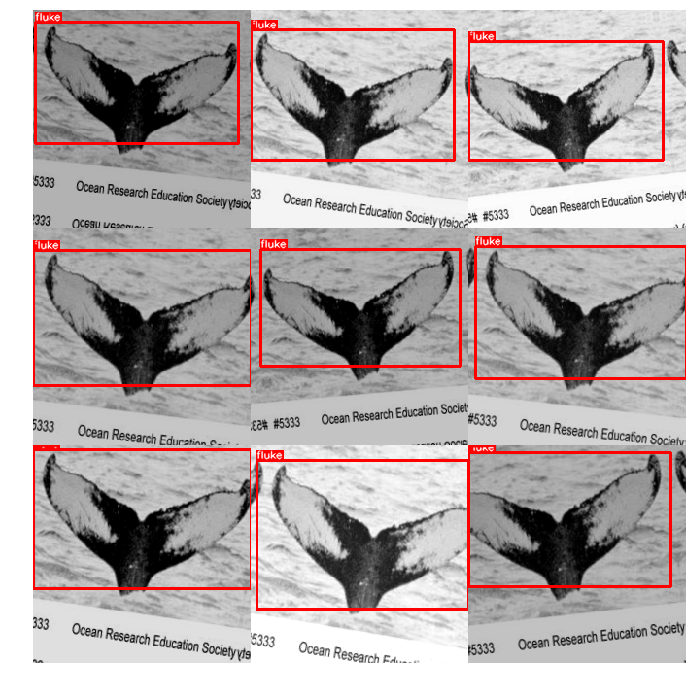

In [8]:
aug = get_aug([albumentations.RandomBrightnessContrast(always_apply=True), albumentations.ShiftScaleRotate(rotate_limit=10, always_apply=True)])

ims = np.stack([visualize(aug(**j2anno(j[1])), cat2name) for _ in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

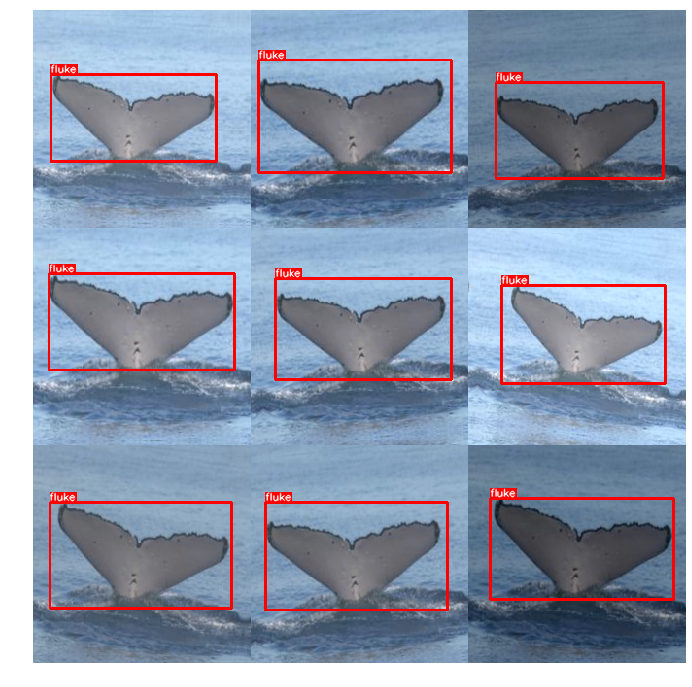

In [9]:
aug = get_aug([albumentations.RandomBrightnessContrast(always_apply=True), albumentations.ShiftScaleRotate(rotate_limit=10, always_apply=True)])

ims = np.stack([visualize(aug(**j2anno(j[8])), cat2name) for _ in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

creating a valiation set

In [10]:
idxs = np.arange(len(j))
np.random.seed(0)
np.random.shuffle(idxs)
val_idxs = idxs[:100]
# val_idxs = pd.to_pickle(val_idxs, 'data/val_idxs_detection.pkl')

In [11]:
val_j = [anno for i, anno in enumerate(j) if i in val_idxs]
trn_j = [anno for i, anno in enumerate(j) if i not in val_idxs]

In [12]:
len(trn_j), len(val_j)

(300, 100)

In [12]:
pd.to_pickle([anno['filename'] for anno in val_j], 'data/val_fns_detection.pkl') # this will allow me to use the same validation set across NBs

In [13]:
class CustomDataset(Dataset):
    def __init__(self, j, aug=None):
        self.j = j
        if aug is not None: aug = get_aug(aug)
        self.aug = aug
    
    def __getitem__(self, idx):
        item = j2anno(self.j[idx])
        if self.aug: item = self.aug(**item)
        im, bbox = item['image'], np.array(item['bboxes'][0])
        im, bbox = self.normalize_im(im), self.normalize_bbox(bbox)
        
        return im.transpose(2,0,1).astype(np.float32), bbox.astype(np.float32)
    
    def __len__(self):
        return len(self.j)
    
    def normalize_im(self, ary):
        return ((ary / 255 - imagenet_stats[0]) / imagenet_stats[1])
    
    def normalize_bbox(self, bbox):
        return bbox / SZ

We are normalizing the coordinates so that the upper left hand corner of the image is (0, 0) and the lower right corner of the image is (1, 1). This is just one of a couple of ways we can make the task easier for our model.

Having said that, this is still going to be quite a crude approach, but maybe because how pronounced the flukes are it will work well enough for our purposes. Other than that, we could try starting with an anchorbox, but I am not sure a single anchorbox would do the trick here. And with multiple anchorboxes we open the pandora's box of the matching problem, non max suppresion, etc. That likely would work better but it would end up being a mini project in its own right.

Let's see how much mileage we can get out of this simple formulation.

In [14]:
trn_ds = CustomDataset(trn_j, [albumentations.RandomBrightnessContrast(always_apply=True), albumentations.ShiftScaleRotate(rotate_limit=10, always_apply=True)])
val_ds = CustomDataset(val_j)

In [15]:
NUM_WORKERS=12
BS = 64

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [16]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return x.sigmoid_() 

In [17]:
learn = Learner(data_bunch, FlukeDetector(arch=models.resnet50), loss_func=L1Loss())

In [18]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [19]:
learn.freeze_to(-1)

In [20]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,0.408424,0.376681
2,0.401695,0.359204
3,0.371626,0.227753
4,0.304638,0.082395
5,0.248492,0.096553
6,0.211106,0.078071
7,0.184315,0.081488
8,0.164117,0.072689
9,0.147799,0.070481
10,0.134886,0.071228


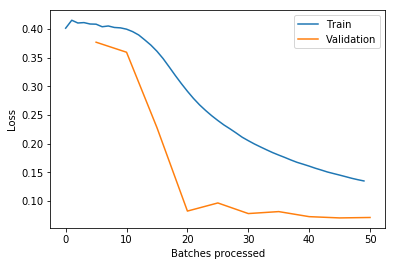

In [21]:
learn.recorder.plot_losses()

It's not easy to tell if a loss of 0.05 is any good or not. Seems our model is not doing a whole lot. Let's add the IoU metric to see where we are.

In [22]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [23]:
learn.metrics = [lambda preds, targs: IoU(preds, targs).mean()]

In [24]:
learn.validate()

[0.0712281, tensor(0.6714)]

In [25]:
learn.unfreeze()

In [26]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [27]:
learn.fit_one_cycle(40, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.062876,0.068007,0.681716
2,0.061231,0.066064,0.687528
3,0.060248,0.064598,0.690616
4,0.059665,0.061074,0.703015
5,0.059679,0.063707,0.691730
6,0.058157,0.060346,0.709634
7,0.057333,0.058324,0.713197
8,0.056889,0.056087,0.707555
9,0.056375,0.050596,0.747323
10,0.055098,0.049386,0.742763


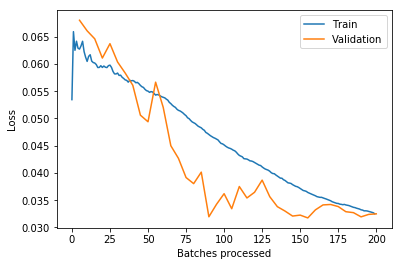

In [28]:
learn.recorder.plot_losses()

In [29]:
preds, targs = learn.get_preds()

Let's take a look at the results.

In [30]:
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()

In [31]:
def draw_bbox(img, bbox, target=None, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

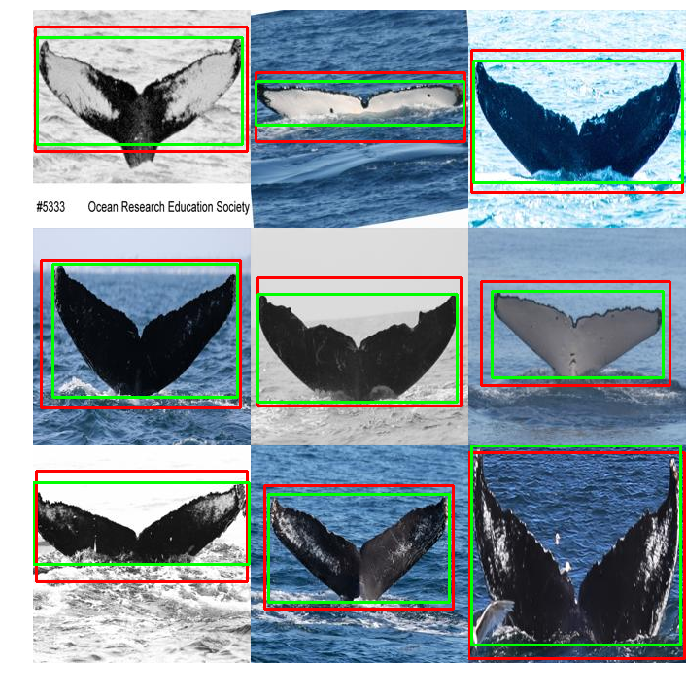

In [32]:
ims = np.stack([draw_bbox(j2anno(val_j[i])['image'], predicted_bboxes[i], targets[i]) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

This turned out to work better than I expected. The predicted bounding boxes seem to err on being too big rather than too small. I think this might be due to the augmentation we are using (rotation). Anyhow, this is likely good enough for our purposes.